In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
TRAIN = True
TRAIN_MODEL_3 = False

TRAIN_TEST_SPLIT_SEED = 442
TEST_SIZE = 0.08
TRAIN_FROM_CP = True  

# CP===check point

EPOCHS = 120
LR = 0.0001

#learning rate

TEST_FLOW = False
DEBUG = False


# CHECKPOINT_URL = 'runs:/4b69983a0ad14c5bba314c9c47c8ee0b/model'
CHECKPOINT_URL = None

In [3]:
import sys

IN_COLAB = 'google.colab' in sys.modules

print (f'Running in colab: {IN_COLAB=}')
print (f'{TRAIN_FROM_CP=}')
print (f'{LR=}')
print (f'{EPOCHS=}')
print (f'{TRAIN=}')
print (f'{DEBUG=}')

Running in colab: IN_COLAB=False
TRAIN_FROM_CP=True
LR=0.0001
EPOCHS=120
TRAIN=True
DEBUG=False


In [4]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [5]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [6]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams


if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

    
    
work_dir = Path(analyser.hyperparams.work_dir)
training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'
    
print(f'{analyser.hyperparams.work_dir=}')
print(f'{training_reports_path=}')
print(f'{work_dir=}')

assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.3.6
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
analyser.hyperparams.work_dir='/root/artem/work'
training_reports_path=PosixPath('/root/artem/analyser/training_reports')
work_dir=PosixPath('/root/artem/work')


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [7]:
%matplotlib inline
import tensorflow as tf
print(f'{tf.__version__=}')



import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

 
import random
 

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-03-10 21:48:39.576685: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


tf.__version__='2.5.0'


/tmp/ipykernel_1936286/818500624.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


# Init mlflow

In [8]:
import mlflow


ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')
mlflow.set_experiment("Обучение анализатора")

mlflow.tensorflow.autolog()

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


In [9]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [10]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [11]:
if DEBUG:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

In [12]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
if DEBUG:
    stats

In [13]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]

print(f'{len(user_dataset)=}')
print(f'{len(stats)=}')


mlflow.log_param('dataset_len_user', len(user_dataset) )
mlflow.log_param('dataset_len', len(stats) )

len(user_dataset)=1243
len(stats)=2066


2066

In [14]:
if DEBUG:
    user_dataset[user_dataset.subj_len>=150]

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [15]:
errors_file = training_reports_path / 'user_markup_errors.csv'
print(f'{errors_file=}')
errors_df = pd.read_csv(errors_file, index_col=0)
errors_df

errors_file=PosixPath('/root/artem/analyser/training_reports/user_markup_errors.csv')


,дата редактирования,link,error,error missing,errors count,errors severity,subject len,subject kind,Форма собственности 1,Наименование 1,...,Дата,сумма,сумма без налога,currency,сумма (старая),Номер,налог,vat_unit,сумма с налогом,subject
5fb3d7a378df3635f5441d8e,2023-03-06 06:38:10.887,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,валюта налога не указана;\n,Номер отсутсвует;\nДата отсутсвует;\n,3,42,58.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,NaN,Заказчик выплачивает Исполнителю вознаграждени...,NaN,рублей,NaN,NaN,"9833,33",NaN,59000,NaN
5fe4821db770574a005556be,2023-02-27 09:03:20.551,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,валюта налога не указана;\n,Форма собственности 2 отсутсвует;\n,2,41,44.0,Deal,Общество с ограниченной ответственностью,Издательскополиграфическое предприятие «Мастер...,...,«10» апреля 2020,2.1. Цена настоящего контракта составляет 2489...,NaN,рублей,NaN,15,41488,NaN,248928,NaN
5fdb2140542ce403c92b4549,2023-03-06 09:45:18.868,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,валюта налога не указана;\n,NaN,1,40,59.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город»,...,«19» сентября 2019,3.2. Сумма настоящего договора составляет 1778...,NaN,рублей,NaN,№ 19-36Д,"296,40",NaN,"1778,40",NaN
5fe4821eb770574a00555724,2023-02-28 07:49:56.198,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,валюта налога не указана;\n,NaN,1,40,34.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,«25» мая 2020,4.1. Цена Договора определяется спецификацией ...,NaN,рублей,NaN,№ 29/09-2020,26666.66,NaN,"160000,00",NaN
5fe48222b770574a005557ee,2023-02-27 09:40:44.213,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,валюта налога не указана;\n,NaN,1,40,50.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,«20» февраля 2020,3.1. Стоимость Услуг по настоящему Договору со...,4402260,рублей,NaN,№ ГНР-20/09000/00137/Р/14,880452,NaN,5282712,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fc63d611d0a1603c7a0c96f,2020-12-18 08:10:11.869,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,NaN,NaN,0,0,15.0,Loans,Общество с ограниченной ответственностью,Газпромнефть Научно-Технический Центр,...,«20» январь 2020 год.,"592350330,00 (пятьсот девяносто два миллиона т...",NaN,рублей,"592350330,00",12345,NaN,NaN,NaN,NaN
5fbf75af5d05d73d0295faaf,2020-11-26 12:33:58.306,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,NaN,NaN,0,0,64.0,Renting,Общество с ограниченной ответственностью,Газпромнефть-Заполярье,...,«01» июля 2020,42966073 (сорок два миллиона девятьсот шестьде...,NaN,рубля,42966073,№ ГНЗ-20/04300/00415/Р/01-03,NaN,NaN,NaN,NaN
5fbbe46ea2b4551c06107c9a,2020-11-24 08:01:14.664,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,NaN,NaN,0,0,114.0,Insurance,Акционерное общество,Арктика Медиа,...,«29» января 2020,Общая страховая премия по настоящему Договору ...,NaN,рублей,447716,№ 2920 LM 0057,NaN,NaN,NaN,NaN
5fbbe46ba2b4551c06107bd3,2020-11-24 07:57:26.973,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,NaN,NaN,0,0,36.0,Service,Акционерное общество,Арктика Медиа,...,«15» июня 2020,"превышать 1139840,00 (Один миллион сто тридцат...",NaN,рублей,"1139840,00",57 ПУ,NaN,NaN,NaN,NaN


In [16]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

# stats.sort_values(['Дата']) 
stats

2066


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-06 14:57:59.719721,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,-3.676084e+18,1.0,2.629557,108.608794
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-06 14:58:02.840701,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,4.114182e+18,1.0,0.618200,55.453157
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.169281e-01,-2.326586e+18,1.0,0.154105,30.079375
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.199301e+18,4.0,2.602203,3.611202
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-2.951830e+18,2.0,2.615742,40.814148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ce4a02e83d1ee490f3f2cd,db,395c9274717cf6052faa2348baa2f4c5,23.01.23,2023-03-02 18:17:42.175010,90.0,2023-01-24 17:25:11.981000+00:00,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,-6.176643e+18,1.0,0.453709,0.523950
63c506d5e2456d59975e1389,db,2628dbfa46813bc351104e1ebdc6d6a2,23.01.04,2023-03-02 18:17:32.130682,2170.0,2023-01-16 11:21:48.816000+00:00,NaN,NaN,NaN,NaN,...,318.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.665437e+07,-9.401634e+17,1.0,0.463146,0.540669
63ce4a7ce83d1ee490f3f9e4,db,b0e10d1baad50f80a892c135e8b0d31c,23.01.23,2023-03-02 18:17:44.323394,550.0,2023-01-25 08:08:48.990000+00:00,NaN,NaN,NaN,NaN,...,252.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,9.065782e+17,1.0,0.460679,0.503592


In [17]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [18]:
%%time

import datetime

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  #error weight
  error_weight = 1.0 
  if i in errors_df.index:
      error_weight = 1.0 + errors_df.at[i, 'errors severity']


  sample_weight = 0.5 
  value_weight = 1.0
    
  if i in errors_df.index:
       
      if type(errors_df.at[i, 'Дата'])==str:
#             print (errors_df.at[i, 'Дата'], i, 'EXISTS')
          value_weight *=1.5
    
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly    

  
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
    
  sample_weight /= error_weight  

  stats.at[i, 'subject_weight'] = subject_weight + random.random()*0.05
  stats.at[i, 'sample_weight'] = sample_weight + random.random()*0.05

# normalize weights, so the sum == Number of samples
# stats.sample_weight /= stats.sample_weight.mean()
# stats.subject_weight /= stats.subject_weight.mean()

print(f'{stats.sample_weight.mean()=}')
print(f'{stats.subject_weight.mean()=}')
print(f'{stats.sample_weight.min()=}')
print(f'{stats.subject_weight.min()=}')
print(f'{stats.sample_weight.max()=}')
print(f'{stats.subject_weight.max()=}')

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

# stats

stats.sample_weight.mean()=18.750577810946552
stats.subject_weight.mean()=0.3420172930290957
stats.sample_weight.min()=0.5000056680554661
stats.subject_weight.min()=0.11357339391186132
stats.sample_weight.max()=120.13199754345763
stats.subject_weight.max()=5.414797621502594
CPU times: user 210 ms, sys: 5.18 ms, total: 215 ms
Wall time: 218 ms


In [19]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [20]:
%%time


from tf_support.super_contract_model import  validate_datapoint

# stats['valid'] = True
stats['error'] = ''

 
for i in stats.index:

  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
# stats

 

umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

ERROR - 2023-03-10 21:48:45,526 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e51bd24992aa3104108-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:48:45,528 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040f2-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:48:45,889 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e51bd24992aa3104122-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:48:46,721 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040e1-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:48:48,542 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506d0e2456d59975e1327-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:48:48,619 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/631afdab4375f5ba58806291-datapoint-embeddings.npy'
ERROR - 20

2055
CPU times: user 1.7 s, sys: 5.69 s, total: 7.39 s
Wall time: 10.4 s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [21]:

len(stats_valid)

2055

In [22]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()





18.772808486980324
0.34179289467394003


/root/artem/env/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MAX\t', stats.sample_weight.max())
print('MEAN\t', stats.sample_weight.mean())

1.0
0.33228717062771845


sample_weight
MIN	 0.026634569270881314
MAX	 6.3992554777711534
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


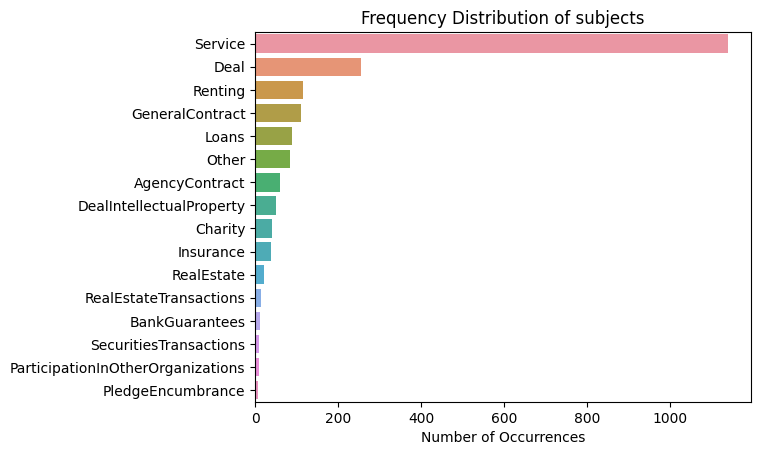


min 6
max 1140
total 2055


In [24]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
fig=plt.figure()
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()
mlflow.log_figure(fig, 'Distribution of subjects.png')

print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [25]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['BankGuarantees', 'AgencyContract', 'Service', 'Charity', 'Loans', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'DealIntellectualProperty', 'PledgeEncumbrance', 'SecuritiesTransactions', 'Renting', 'RealEstate', 'Deal', 'GeneralContract', 'Insurance', 'Other']


Service                              0.483830
Deal                                 0.613796
Renting                              0.716511
GeneralContract                      0.721839
Loans                                0.756921
Other                                0.764646
AgencyContract                       0.828534
DealIntellectualProperty             0.866264
Charity                              0.917176
Insurance                            0.936335
RealEstate                           1.086272
RealEstateTransactions               1.228454
BankGuarantees                       1.370675
SecuritiesTransactions               1.479206
ParticipationInOtherOrganizations    1.479206
PledgeEncumbrance                    1.750337
Name: subject, dtype: float64

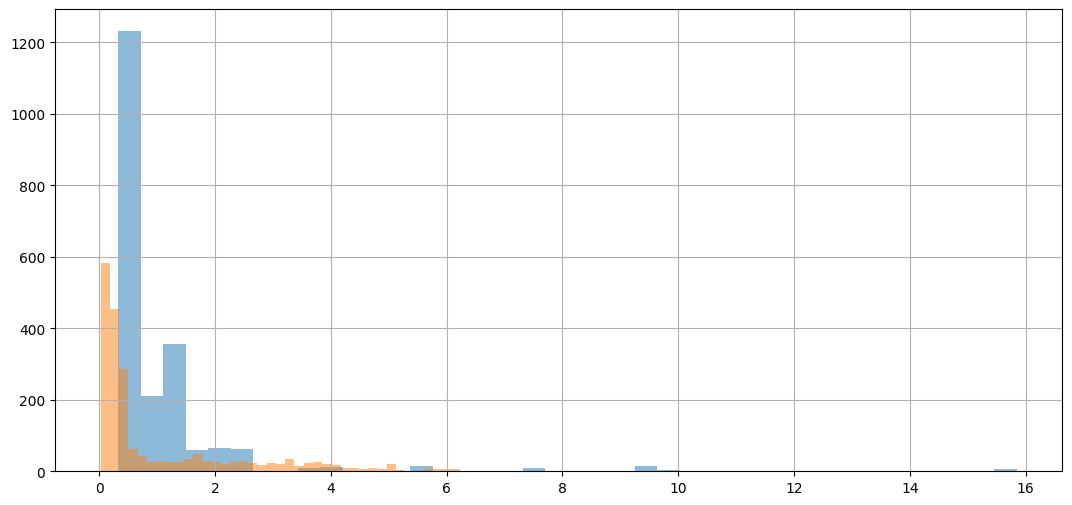

In [26]:
from trainsets.trainset_tools import get_feature_log_weights
 

fig = plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()
mlflow.log_figure(fig, 'Weights Distribution.png')

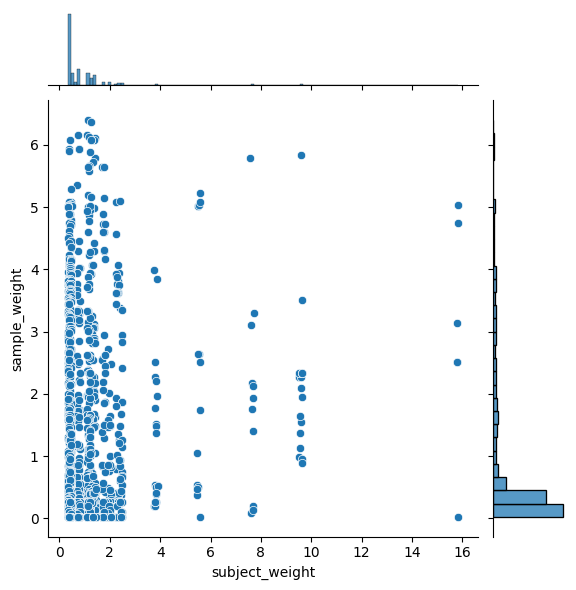

In [27]:
# fig = plt.figure(figsize=(13, 6))

p = sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()
# print(p)

# look into trainset (take a sample)

In [28]:
%matplotlib inline
# umtm.calculate_samples_weights()
 
if DEBUG:   
    SAMPLE_DOC_ID =  stats_valid.index[2]

    print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)


    print('semantic map shape is:', sm.shape)
    _crop = 500
    # plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
    # plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
    plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



In [29]:

if DEBUG:   
    plot_embedding(sm[:, 1::2][:200], title=f'Semantic map {SAMPLE_DOC_ID}')

In [30]:
if DEBUG:   
    nonzerozz = np.where(sm[:, 1::2] > 0)[0]
    max_len = 1536
    # nonzerozz = list(set(nonzerozz))
    # nonzerozz

    # c=random.choice(nonzerozz)
    # sm[c-1:c]
    sm = sm*100.
    for i in range(0,2000):
        segment_center = random.choice(nonzerozz)

        _off = random.randint(-max_len//40, max_len//2)
        start_from = segment_center - _off
        if start_from < 0:
            start_from = 0
        if start_from >=len(emb):
            start_from = len(emb)-1

        sm[start_from: start_from+max_len]+=1

    plot_embedding(sm, title=f'Semantic map {SAMPLE_DOC_ID}')


In [31]:
# # sm[1].argmax()
# for i in range(0,10):
#     print(random.random() < 0.8)
# #     random_row = random.randint(0, sm.shape[-1])
# #     focus_pos = sm[random_row].argmax()
# #     print(random_row, focus_pos, sm[random_row][focus_pos])

# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

semantic map shape is: (10, 1293, 30)


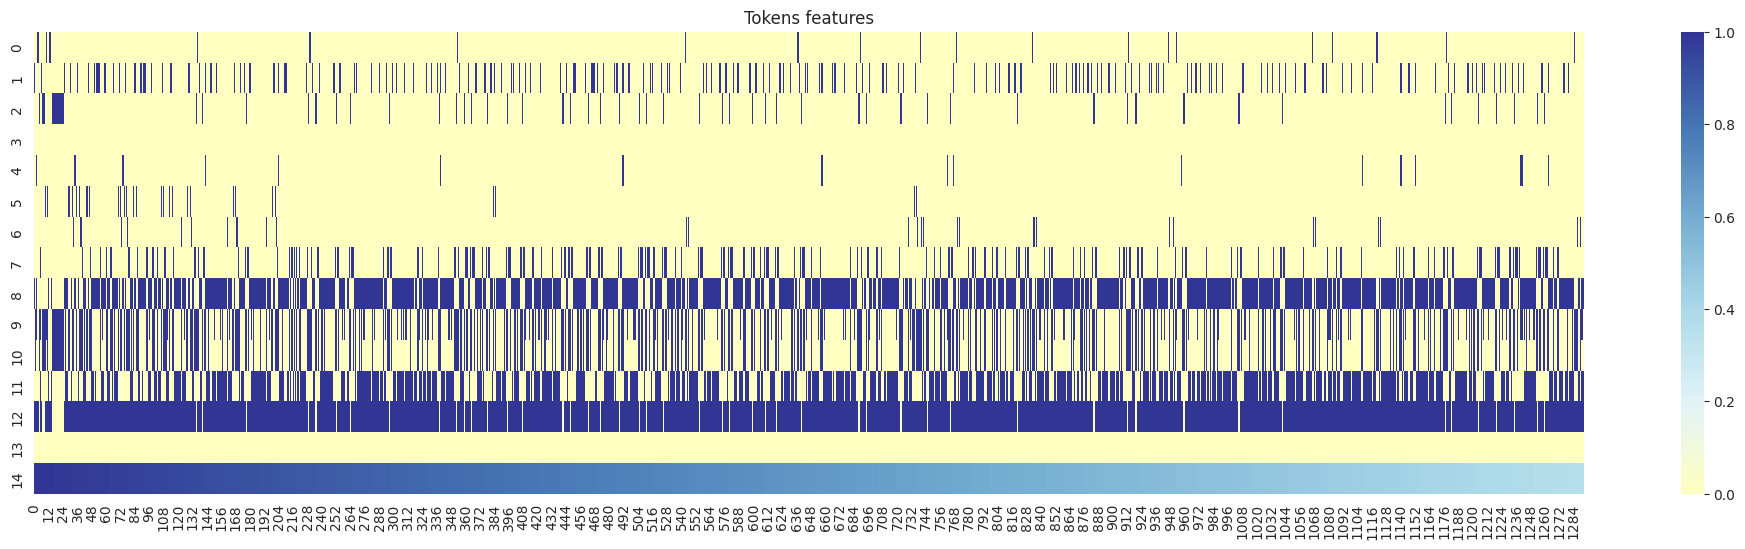

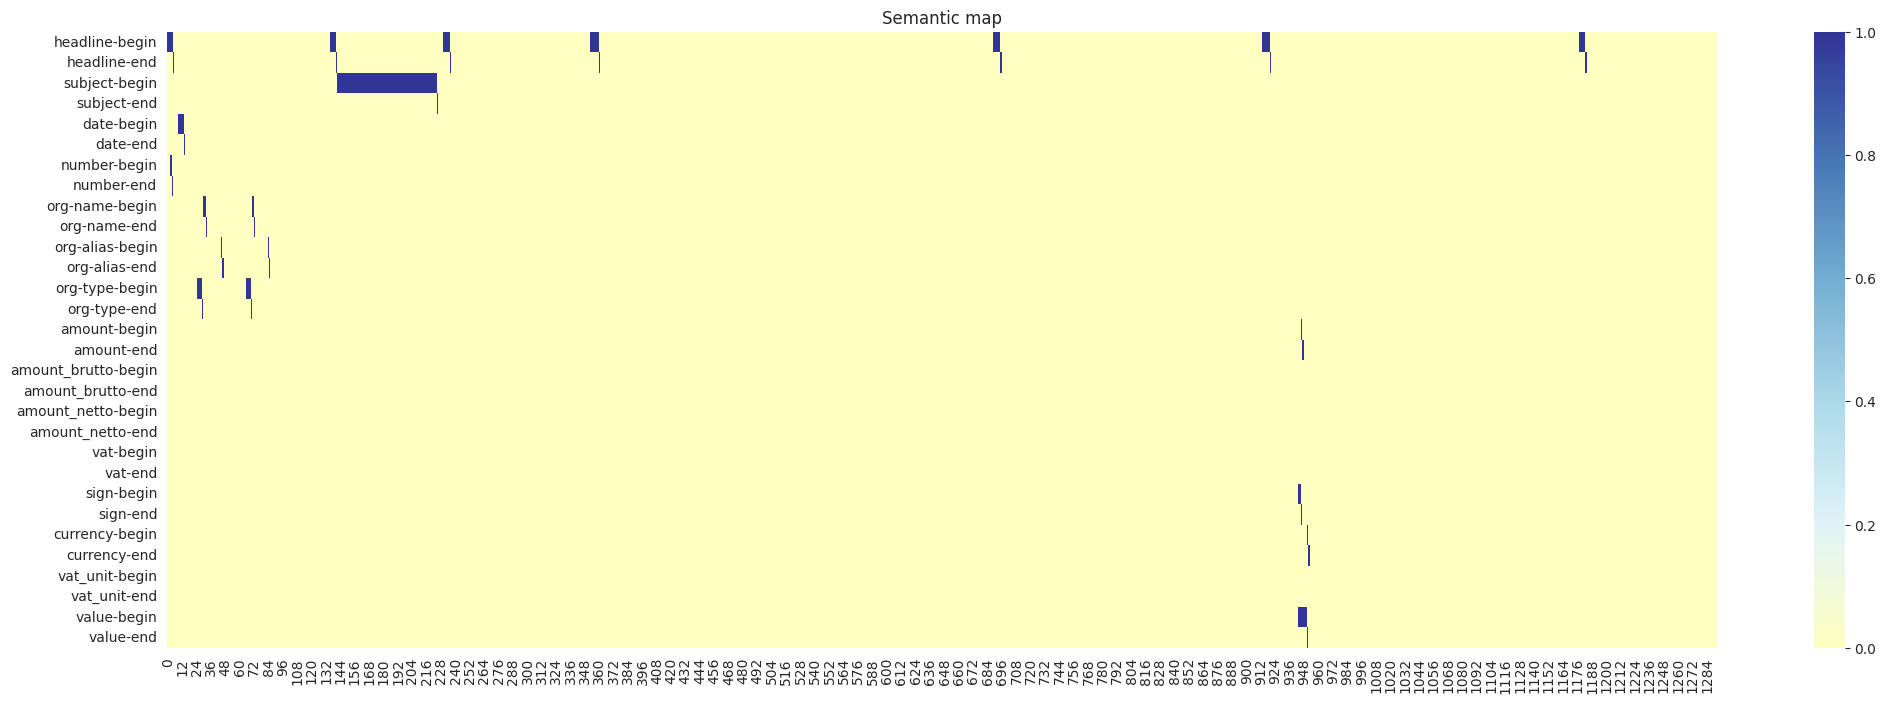

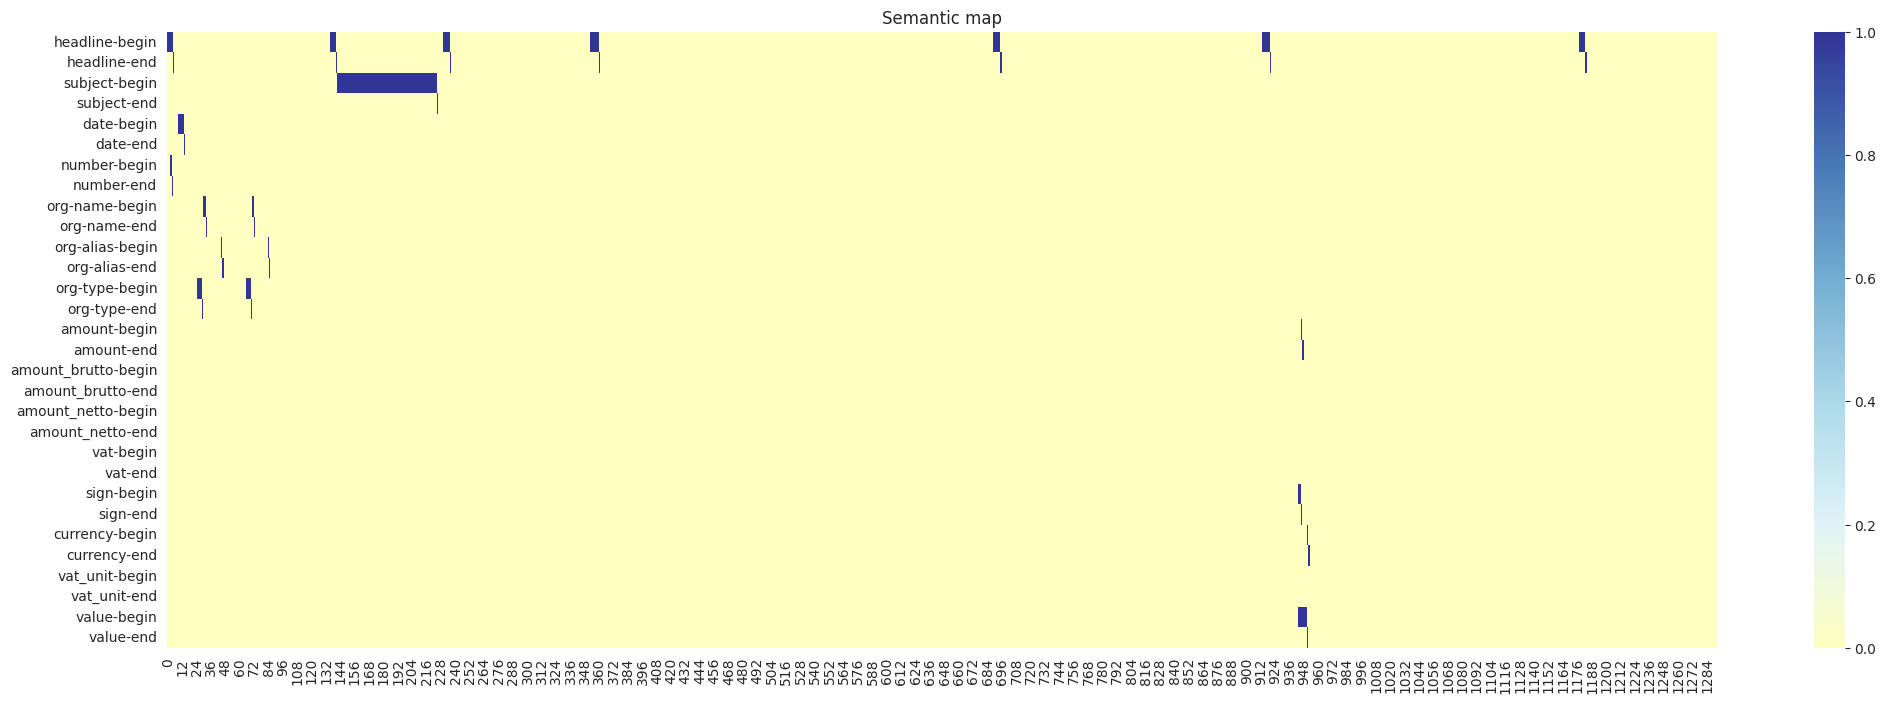

In [32]:


MAX_LEN = 1536
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  #   np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = MAX_LEN
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, MAX_LEN)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      #       print(dp)

      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        # row = stats_valid.loc[doc_id]
        if random.random() < 0.6:  # 60% of samples
          nonzerozz = np.where(sm[:, 1::2] > 0)[0] #take every second row, because these are end marks
#           nonzerozz = nonzerozz
          
          segment_center = random.choice(nonzerozz)
          if len(nonzerozz)==0:
             segment_center=0


          # segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center

          # if not pd.isna(row['value_span']) and random.random() < 0.7:  ##select value token as a center
          #   segment_center = int(row['value_span'])

          # _off = random.randint(max_len // 4, max_len // 2)
          _off = random.randint(-max_len//10, max_len//2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          if start_from >=len(emb):
            start_from = len(emb)-1
#           print('start_from', start_from)
#           if random_row != 1:#subject row, see semantic_map_keys
#               subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)

      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      #       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
    #     print('batch_output_subj', len(batch_output_subj))
    #     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=TEST_SIZE, stratify=stats_valid[['subject']], random_state=TRAIN_TEST_SPLIT_SEED)

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, batch_size=10, augment_samples=True)

sample = next(_gen)
# print(len(sample))
del _gen
 
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
    
print('semantic map shape is:', sm.shape)
_crop = 1500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(pd.DataFrame( sm[0], columns= semantic_map_keys_contract) [:_crop],    title=f'Semantic map', height=8)

## Diagnose SM Rows in TS

In [33]:
# plot_embedding(pd.DataFrame( sm[0], columns= semantic_map_keys_contract) [:_crop],    title=f'Semantic map', height=8)
if DEBUG:
    _crop = 350
    batch_size=100
    mtx = np.zeros((batch_size, _crop))


    _gen = make_generator(umtm, train_indices, batch_size=batch_size, augment_samples=True) 

 


    for i in range(0, batch_size):

        sample = next(_gen)
        (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample


        sub = sm[0][:,4:6][:_crop] #pd.DataFrame( sm[0], columns= semantic_map_keys_contract) [:_crop][['date-begin']]

    #     print(sub[:,0].max())
        mtx [i][0:len(sub[:,0])] = sub[:,0]

    fig = plot_embedding(mtx.T,    title=f'Semantic map, combined Date rows of {batch_size} samples', height=5)
    mlflow.log_figure(fig, 'Diagnose SM Rows in TS.png')
    del _gen
    del mtx

In [34]:
mlflow.log_param('dataset_len_train', len(train_indices) )
mlflow.log_param('dataset_len_test', len(test_indices) )

165

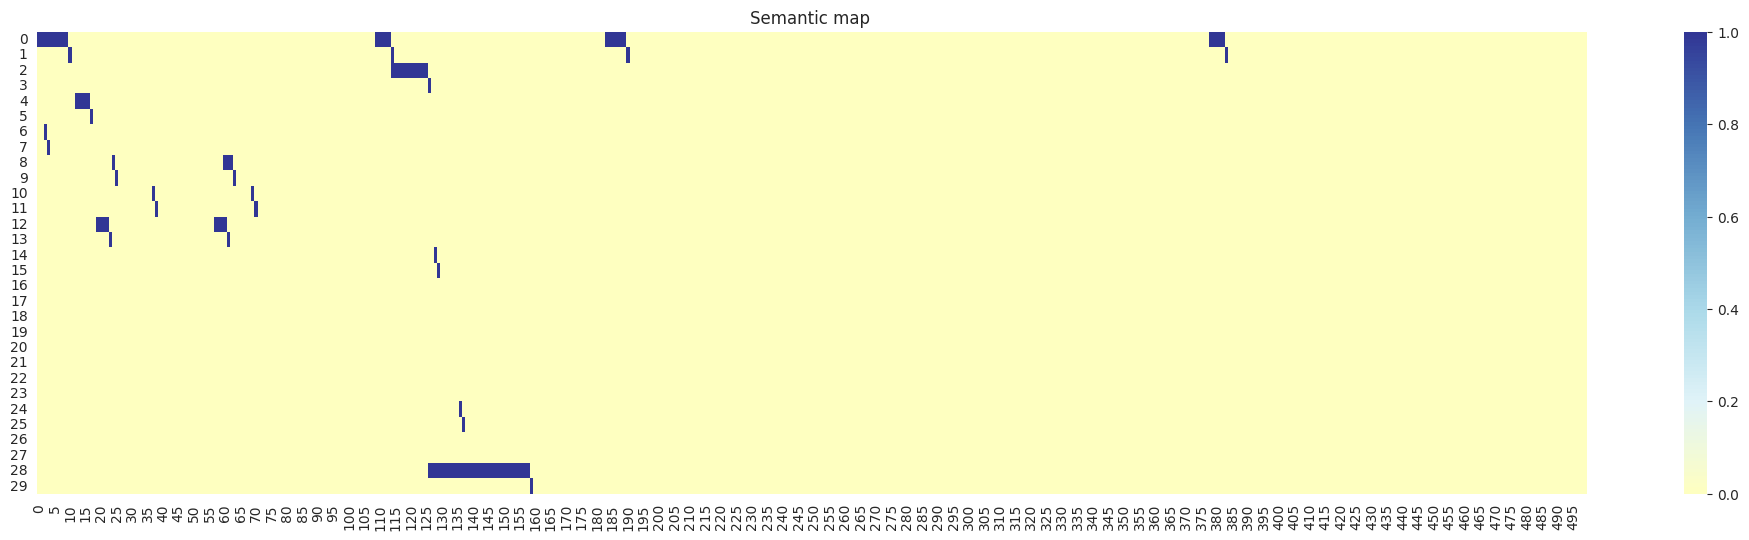

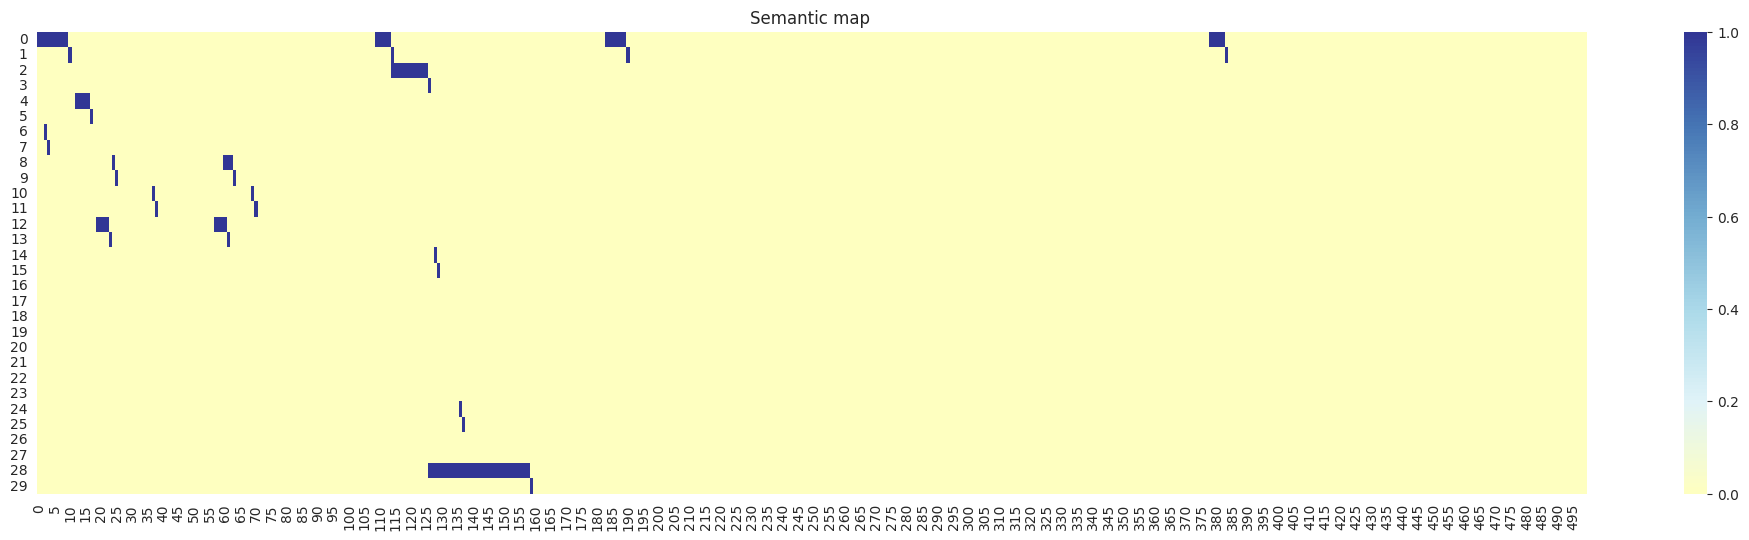

In [35]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5fc7a035c54bc33809e261e1
test_indices[0]: 615ac8cf8f3b0514f3f423f8


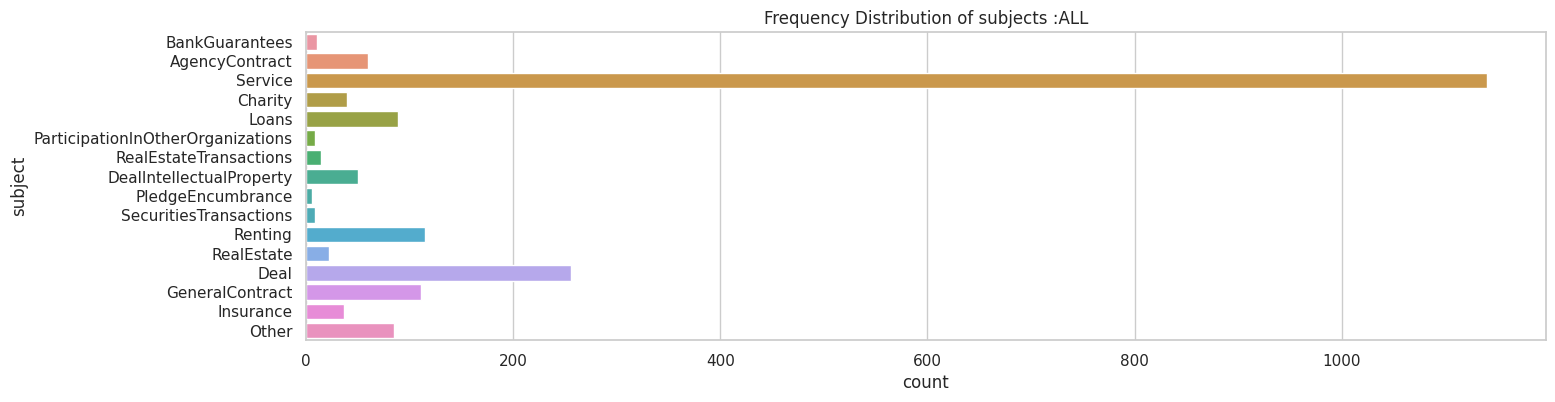

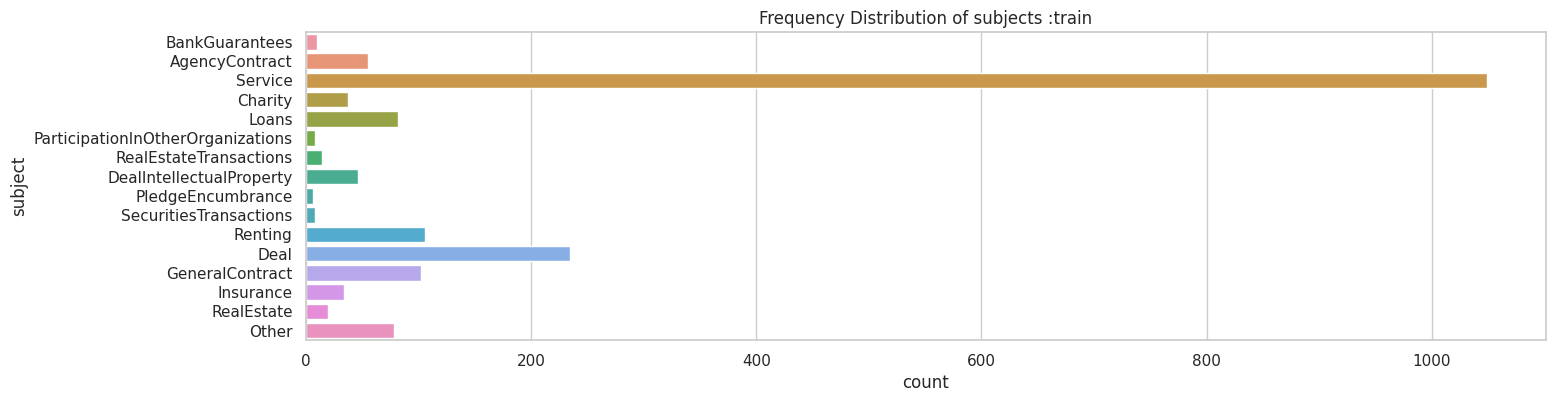

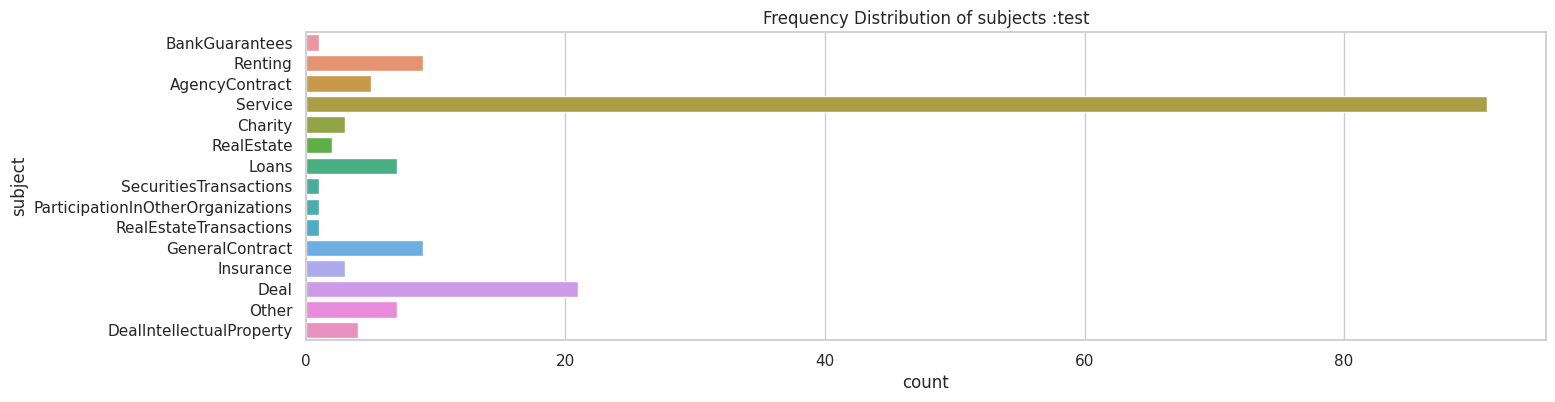

In [36]:

BATCH_SIZE = 72
EMB =  1024
 


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  fig = plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  t = f'Frequency Distribution of subjects :{title}'
  plt.title(t)
  mlflow.log_figure(fig, f'{t}.png')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')



if DEBUG:   
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [37]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	72
train_samples:	7560
test_samples:	165
steps_per_epoch:	105
validation_steps:	52


# Models 🦖

In [38]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

In [39]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 


## 🥰 Att model

In [40]:
from tf_support.tools import KerasTrainingContext
from tf_support.super_contract_model import config, make_att_model

model_factory_fn = make_att_model      
# TRAIN_FROM_CP = True
if TRAIN_FROM_CP:
    weights = get_weights_filename(model_factory_fn)
else:
    weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
    
# weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'


# TRAIN_FROM_CP=True        
if not TEST_FLOW:
    
    umodel = make_att_model() 
    print(f'{umodel.name=}')    

    if CHECKPOINT_URL is not None:
        logger.info(f'LOADING {CHECKPOINT_URL}')
        umodel = mlflow.tensorflow.load_model(CHECKPOINT_URL)
    else:
        if TRAIN_FROM_CP:
            logger.info(f'LOADING {weights}')
            print(f'LOADING {weights=}')
            umodel.load_weights(weights, by_name=True, skip_mismatch=True)
        else:
            logger.warning(f'skip loading weights, because {TRAIN_FROM_CP=}')

    # if DEBUG:    
    umodel.summary()

# raise "forsibly stopped"


True /root/artem/analyser/training_reports/make_att_model_03.h5


2023-03-10 21:49:03.451252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-10 21:49:03.952535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:49:03.953191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-10 21:49:03.953212: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-10 21:49:03.953254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-10 21:49:03.953272: I tensorflow/stream_executor/platform/defa

umodel.name='make_att_model_03'
Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb_norm (LayerNorma (None, None, 1024)   2048        input_text_emb[0][0]             
__________________________________________________________________________________________________
token_features_norm (LayerNorma (None, None, 15)     30          token_features[0][0]             
__________________________________________________

In [41]:
# dot_img_file = f'{umodel.name}.png'
# keras.utils.plot_model(umodel, to_file=dot_img_file, show_shapes=True)

In [42]:
def train_and_evaluate_model(self, model:Model, generator, test_generator, retrain=False, lr=None):
    print(f'model.name == {model.name}')
    self.trained_models[model.name] = model.name
    if self.EVALUATE_ONLY:
      print(f'training skipped EVALUATE_ONLY = {self.EVALUATE_ONLY}')
      return

    _log_fn = f'{model.name}.{self.session_index}.log.csv'
    _logger1 = CSVLogger(self.model_checkpoint_path / _log_fn, separator=',', append=not retrain)
    _logger2 = CSVLogger(_log_fn, separator=',', append=not retrain)

    checkpoint_weights = ModelCheckpoint(self.model_checkpoint_path / (model.name + ".h5"),
                                         monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True,
                                         verbose=1)

    lr_logged = None
    if not retrain:
      lr_logged, epoch = self.get_lr_epoch_from_log(model.name)
    else:
      epoch = 0

    if lr_logged is not None:
      K.set_value(model.optimizer.lr, lr_logged)

    if lr is not None:
      K.set_value(model.optimizer.lr, lr)

    print(f'continue: lr:{K.get_value(model.optimizer.lr)}, epoch:{epoch}')


    history = model.fit(
                    generator, batch_size=BATCH_SIZE,
#                     steps_per_epoch=train_steps,
                    epochs=self.EPOCHS,
                    validation_data=test_generator,
                    validation_steps=self.validation_steps,
                    steps_per_epoch=self.steps_per_epoch,
#                     class_weight=class_weights,
                    initial_epoch=epoch, 
#                     workers=8,
                    callbacks=[self.reduce_lr, checkpoint_weights, _logger2, _logger1]
                    )
    
    

    self.HISTORIES[model.name] = history
    self.save_stats(model.name)

    return history


if not TEST_FLOW:

    if TRAIN:
      config.LR = LR
      ctx.unfreezeModel(umodel)
    #   umodel.summary()

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False

      BATCH_SIZE = 96
      test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      train_and_evaluate_model(ctx, umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)
    else:
      logger.warning(f'skip training, because TRAIN={TRAIN}')


    threshold = umodel.get_layer('O1_tagging').get_weights()
    if threshold:
        print('threshold=', threshold[0][0])

        mlflow.log_metric('trained_tags_threshold', threshold[0][0])

model.name == make_att_model_03
continue: lr:9.999999747378752e-05, epoch:0


2023-03-10 21:49:17.868465: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-03-10 21:49:17.868486: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-03-10 21:49:17.872185: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2023-03-10 21:49:17.888297: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2
2023-03-10 21:49:17.994152: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-03-10 21:49:17.995148: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2023-03-10 21:49:18.238477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-10 21:49:18.239316: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/120


2023-03-10 21:49:22.652855: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-10 21:49:24.012426: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-03-10 21:49:24.267525: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-10 21:49:24.267809: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-10 21:49:24.267830: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  1/105 [..............................] - ETA: 11:16 - loss: 0.0509 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0456 - O1_tagging_mse: 9.9210e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0334

2023-03-10 21:49:24.917045: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-03-10 21:49:24.917073: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/105 [..............................] - ETA: 1:28 - loss: 0.0425 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0374 - O1_tagging_mse: 9.0431e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0297 

2023-03-10 21:49:25.610377: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-03-10 21:49:25.612332: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2023-03-10 21:49:25.641859: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 30005 callback api events and 29997 activity events. 
2023-03-10 21:49:25.866342: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-03-10 21:49:26.107225: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25
2023-03-10 21:49:26.263088: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25/tensor.trace.json.gz


  3/105 [..............................] - ETA: 1:33 - loss: 0.0407 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0293    

2023-03-10 21:49:26.458508: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25
2023-03-10 21:49:26.462713: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25/tensor.memory_profile.json.gz
2023-03-10 21:49:26.465809: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25Dumped tool data for xplane.pb to /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25/tensor.xplane.pb
Dumped tool data for overview_page.pb to /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25/tensor.overview_page.pb
Dumped tool data for input_pipeline.pb to /tmp/tmpudmnd0by/train/plugins/profile/2023_03_10_21_49_25/tensor.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to /tmp/tmpudmnd0by/train/plugins/

105/105 [==============================] - 158s 1s/step - loss: 0.0447 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0393 - O1_tagging_mse: 9.0441e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0287 - val_loss: 0.0416 - val_O1_tagging_loss: 0.0043 - val_O2_subject_loss: 0.0372 - val_O1_tagging_mse: 6.9381e-04 - val_O1_tagging_binary_crossentropy: 0.0059 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0267

Epoch 00001: val_loss improved from inf to 0.04157, saving model to /root/artem/analyser/training_reports/make_att_model_03.h5
Epoch 2/120
105/105 [==============================] - 176s 2s/step - loss: 0.0427 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0373 - O1_tagging_mse: 8.5316e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0386 - val_O1_tagging_loss: 0.0041 - val_O2_subject_loss: 0.0345 - val_O1_tagging_mse: 7.0113e-04

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Evaluate last checkpoint

In [43]:
if not TEST_FLOW:
    if umodel:
        del umodel

    #######################################
    #######################################
    model_fn = make_att_model
    # model_fn = uber_detection_model_003
    #######################################
    #######################################


    weights = ctx.model_checkpoint_path /  f'{model_factory_fn.__name__}.h5'
    logger.info(f'LOADING {weights}')
    print(f'LOADING {weights}')

    umodel = make_att_model() 
    umodel.load_weights(weights, by_name=False, skip_mismatch=False)
    umodel.trainable = False
    umodel.summary()

    # umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')



    #TODO: remove next 2 lines
    ctx.trained_models[umodel.name] = umodel.name
    models = ctx.trained_models

INFO - 2023-03-11 02:32:26,580 - retrain_ipynb - LOADING /root/artem/analyser/training_reports/make_att_model_03.h5
INFO:retrain_ipynb:LOADING /root/artem/analyser/training_reports/make_att_model_03.h5


LOADING /root/artem/analyser/training_reports/make_att_model_03.h5
Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb_norm (LayerNorma (None, None, 1024)   2048        input_text_emb[0][0]             
__________________________________________________________________________________________________
token_features_norm (LayerNorma (None, None, 15)     30          token_features[0][0]             
_______________

### training history

loading training log from /root/artem/analyser/training_reports/make_att_model_03.1.log.csv


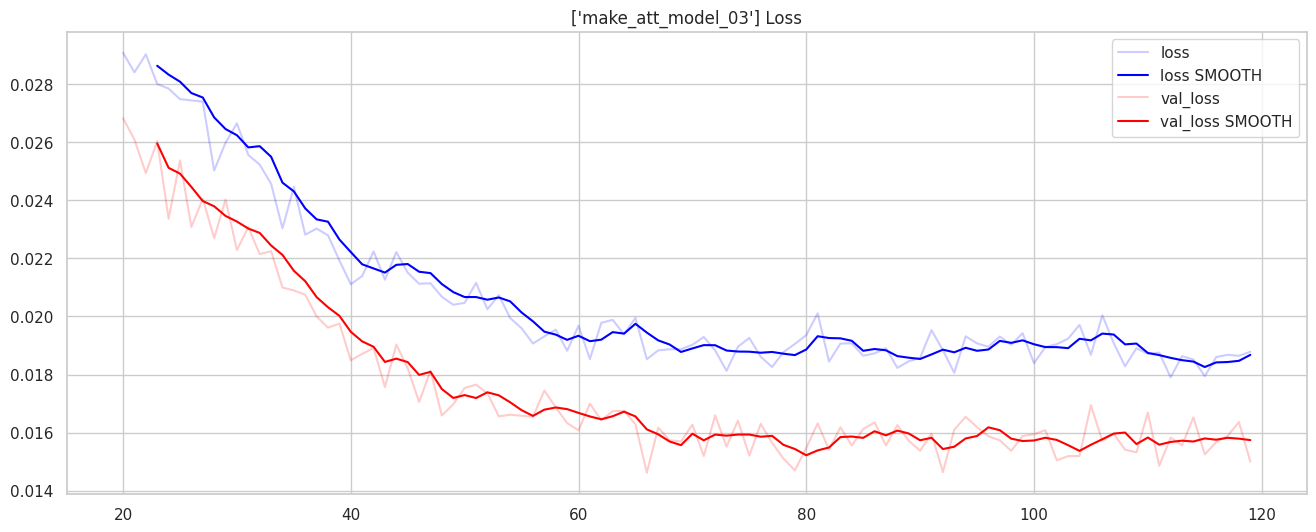

loading training log from /root/artem/analyser/training_reports/make_att_model_03.1.log.csv


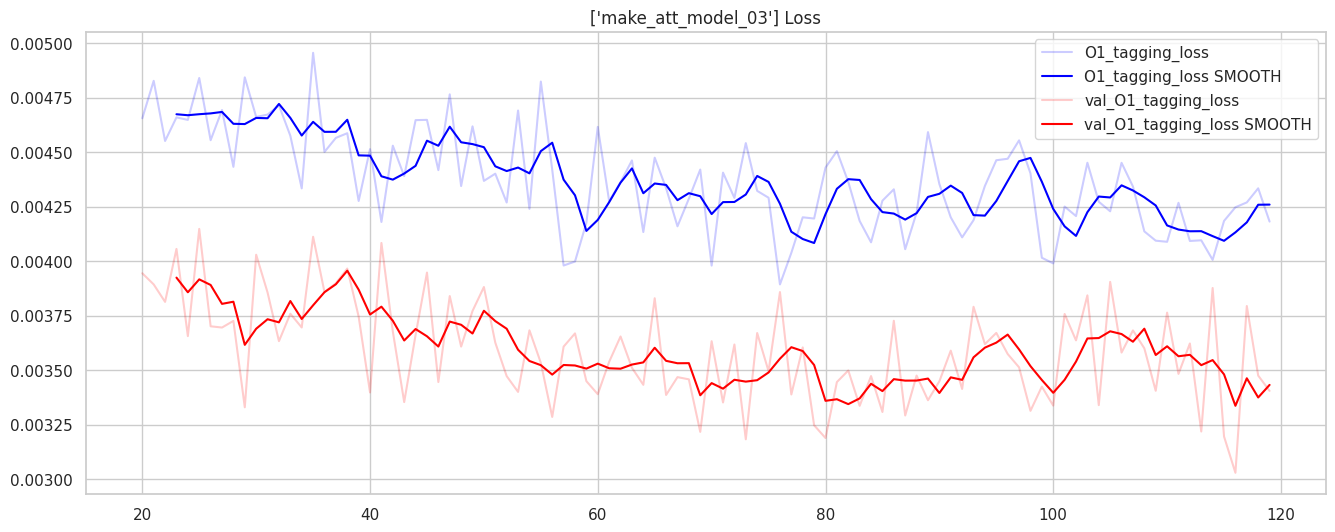

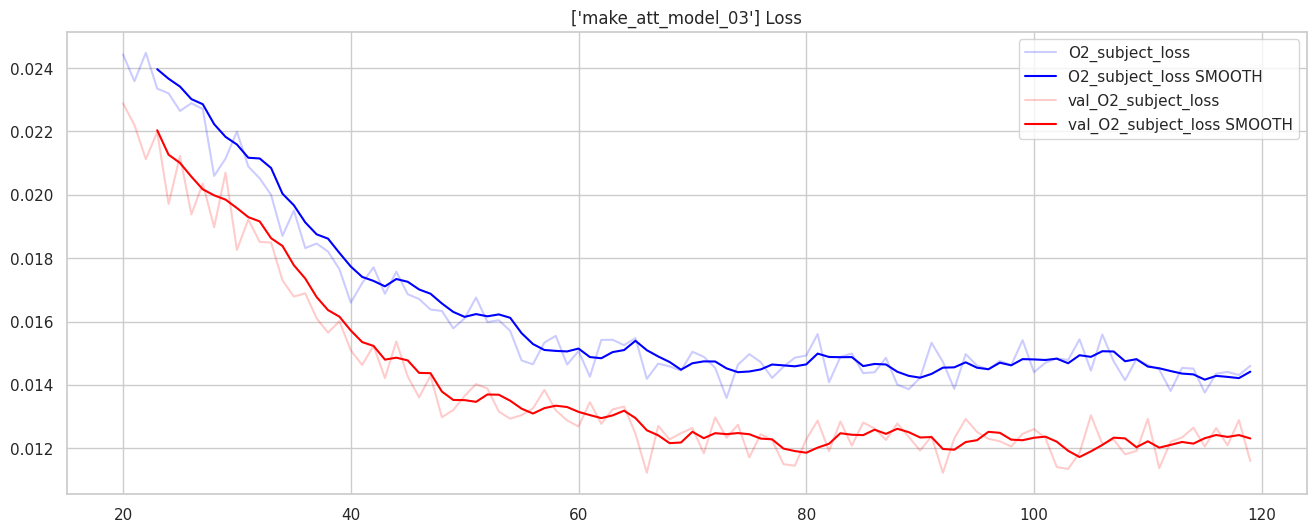

In [44]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    
if not TEST_FLOW:
    models = list(ctx.trained_models.keys())


    plot_compare_models(models, ['loss'], 'Loss')

    # plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
    # plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
    # plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
    # plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

    plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')


In [45]:
from tf_support.super_contract_model import make_xyw
logger.error("fix prediction!!")
if False:
    sample_index = umtm.stats [umtm.stats['value']>0].index[2]
    logger.info(f'making prediction for sample doc {sample_index}')

    x, y, _ = make_xyw(sample_index, umtm.stats)
    print(f'shape of x[0]={x[0].shape}')
    print(f'shape of x[1]={x[1].shape}')

    t1 = np.expand_dims(x[0], axis=0)
    t2 = np.expand_dims(x[1], axis=0)

    print(f'shape of t1={t1.shape}')
    print(f'shape of t2={t2.shape}')
    print(f'umodel.name ={umodel.name}')

    prediction = umodel.predict(x=[t1, t2], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
    # .T
    plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

ERROR - 2023-03-11 02:32:28,335 - retrain_ipynb - fix prediction!!
ERROR:retrain_ipynb:fix prediction!!


# Evaluate recent model (with external notebook)

DEBUG:eva;_ipynb:--=logging started=--
/tmp/ipykernel_1936286/530718550.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
INFO:retrain_contract_uber_model:loading trainset meta from /root/artem/work/contract_trainset_meta.csv
INFO:retrain_contract_uber_model:number of samples BEFORE clean-up: 2426
INFO:retrain_contract_uber_model:number of samples AFTER clean-up: 2425
INFO:retrain_contract_uber_model:OK
INFO:retrain_contract_uber_model:TOTAL DATAPOINTS IN TRAINSET: 2425
INFO:retrain_contract_uber_model:loading trainset meta from /root/artem/work/contract_trainset_meta.csv
INFO:retrain_contract_uber_model:number of samples BEFORE clean-up: 2426
INFO:retrain_contract_uber_model:number of samples AFTER clean-up: 2425


Running in colab: False
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
training_reports_path=PosixPath('/root/artem/analyser/training_reports')
analyser.hyperparams.work_dir='/root/artem/work'
work_dir=PosixPath('/root/artem/work')


INFO:retrain_contract_uber_model:OK
INFO:retrain_contract_uber_model:TOTAL DATAPOINTS IN TRAINSET: 2425
ERROR - 2023-03-11 02:32:31,598 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040e6-datapoint-embeddings.npy'
ERROR:eva;_ipynb:[Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040e6-datapoint-embeddings.npy'
ERROR - 2023-03-11 02:32:31,904 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e51bd24992aa3104108-datapoint-embeddings.npy'
ERROR:eva;_ipynb:[Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e51bd24992aa3104108-datapoint-embeddings.npy'
ERROR - 2023-03-11 02:32:31,907 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040f2-datapoint-embeddings.npy'
ERROR:eva;_ipynb:[Errno 2] No such file or directory: '/root/artem/work/datasets/5f

total docs in /root/artem/work/documents.json is 622


ERROR - 2023-03-11 02:33:06,101 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd52a'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd52a'
ERROR - 2023-03-11 02:33:06,118 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd534'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd534'
ERROR - 2023-03-11 02:33:06,124 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd539'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd539'
ERROR - 2023-03-11 02:33:06,144 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd562'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd562'
ERROR - 2023-03-11 02:33:06,185 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd56e'
ERROR:eva;_ipynb:No key in stats: '5ded07184ddc27bcf92dd56e'
ERROR - 2023-03-11 02:33:06,341 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07194ddc27bcf92dd5ba'
ERROR:eva;_ipynb:No key

errors count: 76
total docs in /root/artem/work/documents.json is 546
TEST_FLOW=False
********************************************************************************
model_factory_fn defined as make_att_model_03
model_factory_fn=<function make_att_model_03 at 0x7fd38c331160>
********************************************************************************
umodel defined as make_att_model_03
Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
____________________________________________________________________________________

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

DB HOST IS: 192.168.10.36


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd38a955160>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd38a955160>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249f20100>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249f20100>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249e9f700>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249e9f700>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

637f2826fe09513dc6b2bfc0 not found in db
637f2826fe09513dc6b2bfbf not found in db
actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd248b574f0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd248b574f0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

637f725ec15a83c52bb2bfc1 not found in db


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249eb2970>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249eb2970>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd534e99ee0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd534e99ee0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd3871f3fa0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd3871f3fa0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249eb7c70>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249eb7c70>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd3895c0c10>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd3895c0c10>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249f3d0a0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
ERROR:gpn:smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7fd249f3d0a0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_n

['AgencyContract', 'BankGuarantees', 'Charity', 'Deal', 'DealIntellectualProperty', 'GeneralContract', 'Insurance', 'Loans', 'ParticipationInOtherOrganizations', 'PledgeEncumbrance', 'RealEstate', 'RealEstateTransactions', 'Renting', 'SecuritiesTransactions', 'Service']
make_att_model_03
                                   precision    recall  f1-score   support

                   AgencyContract      0.974     1.000     0.987        37
                   BankGuarantees      0.769     1.000     0.870        10
                          Charity      0.947     1.000     0.973        18
                             Deal      0.960     0.960     0.960       126
         DealIntellectualProperty      0.895     1.000     0.944        34
                  GeneralContract      0.880     1.000     0.936        73
                        Insurance      1.000     1.000     1.000        22
                            Loans      0.973     0.961     0.967        76
ParticipationInOtherOrganizations  

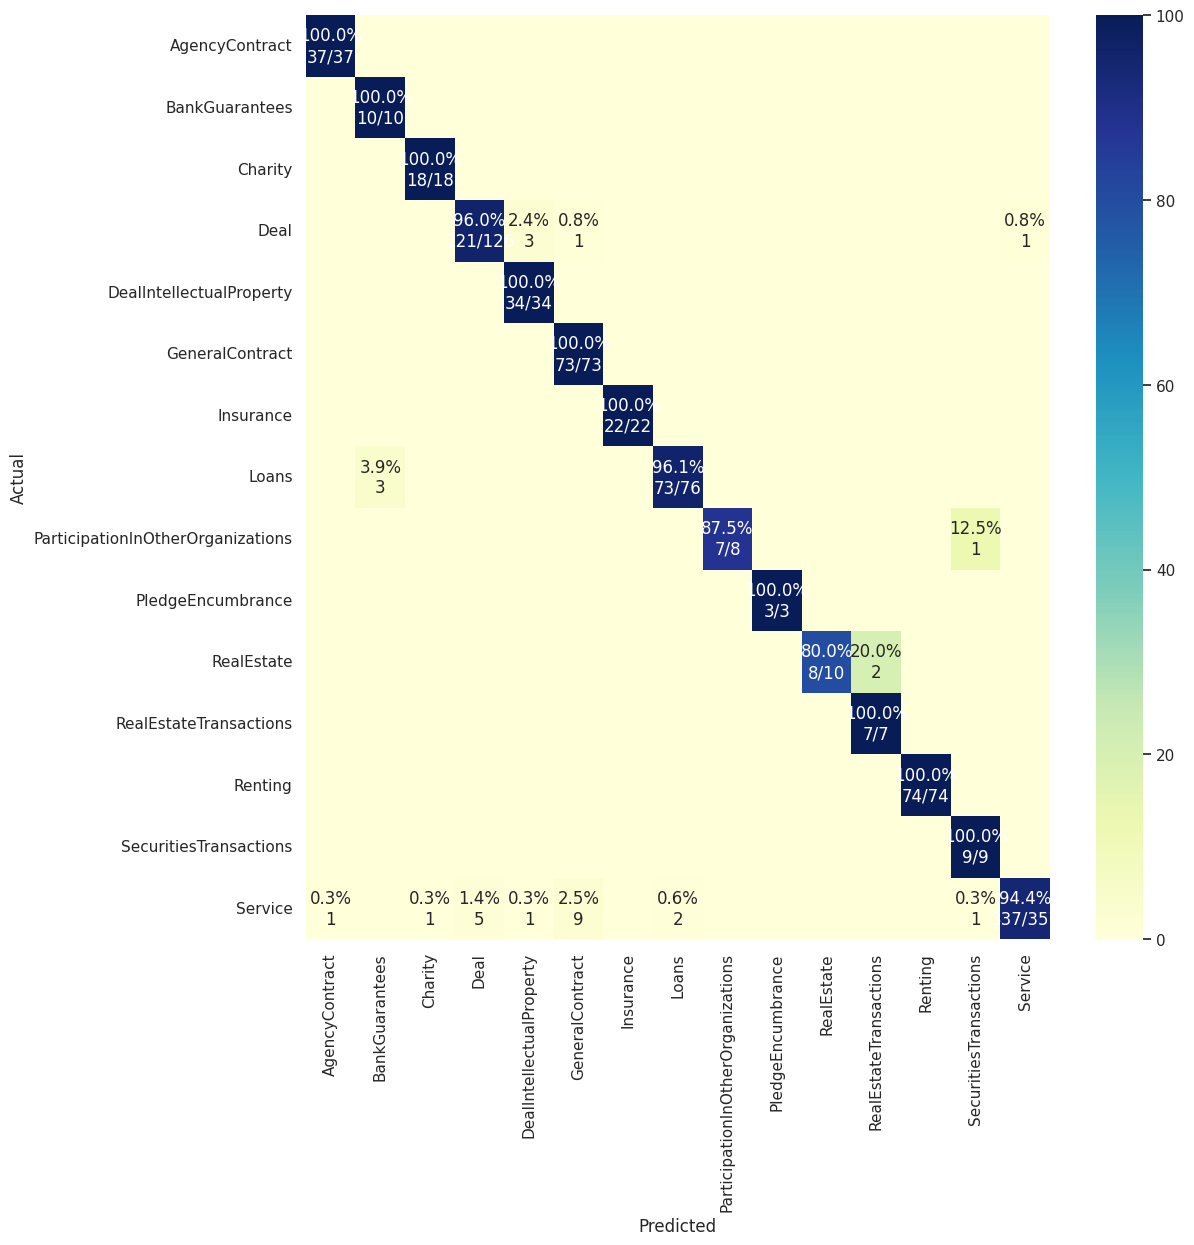

<RunInfo: artifact_uri='mlflow-artifacts:/734503408361585659/66c520812bfe41e5900b358dc21c384f/artifacts', end_time=None, experiment_id='734503408361585659', lifecycle_stage='active', run_id='66c520812bfe41e5900b358dc21c384f', run_name='polite-foal-492', run_uuid='66c520812bfe41e5900b358dc21c384f', start_time=1678491148406, status='RUNNING', user_id='root'>


In [46]:
if not TEST_FLOW:
    %run -i -t /root/artem/analyser/trainsets/eval_contract_uber_model.ipynb
 